<Figure size 1200x500 with 0 Axes>

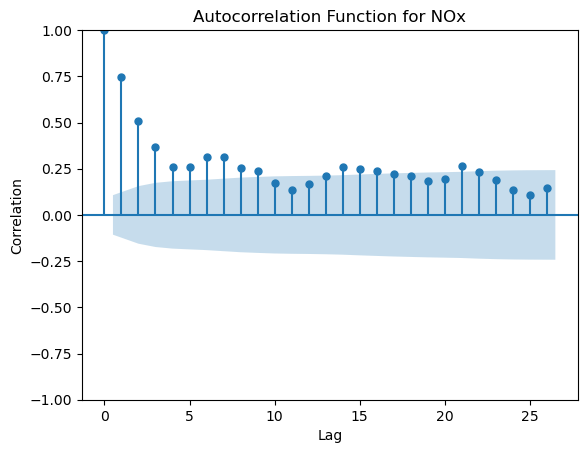

D:\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x500 with 0 Axes>

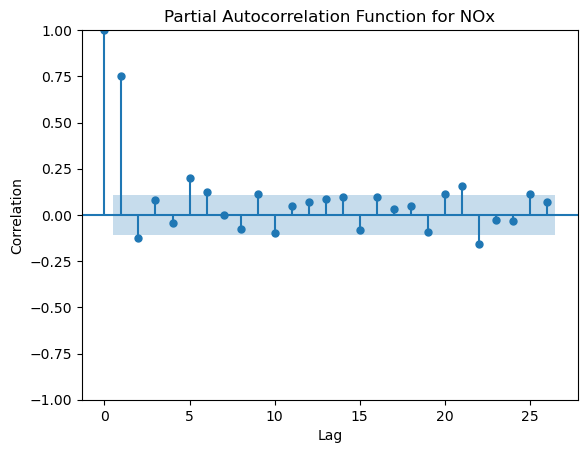

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

file_path = "2020-air-quality-data-continuous.xlsx"
data = pd.read_excel(file_path)

# Split the "geo_point_2d" column into "Latitude" and "Longitude" columns
data[["Latitude", "Longitude"]] = data["geo_point_2d"].str.split(", ", expand=True).astype(float)

# Extract the text before the letter "T" in the "Date" column (i.e., the date)
data["Date"] = data["Date"].apply(lambda x: x.split("T")[0])

# Create a new DataFrame, calculate the mean of each column for each "Date"
columns_to_average = ["NOx","NO2", "NO", "PM10", "NVPM10", "VPM10", "NVPM2.5", "PM2.5", "VPM2.5", "CO", "O3", "SO2", "Temperature", "RH", "Air Pressure"]
averaged_data = data.groupby("Date")[columns_to_average].mean().reset_index()

# Set the date column as the index
# Assume the data is collected monthly
averaged_data = averaged_data.set_index("Date")
averaged_data.index = pd.date_range(start=averaged_data.index[0], end=averaged_data.index[-1], freq='D')



<Figure size 1200x500 with 0 Axes>

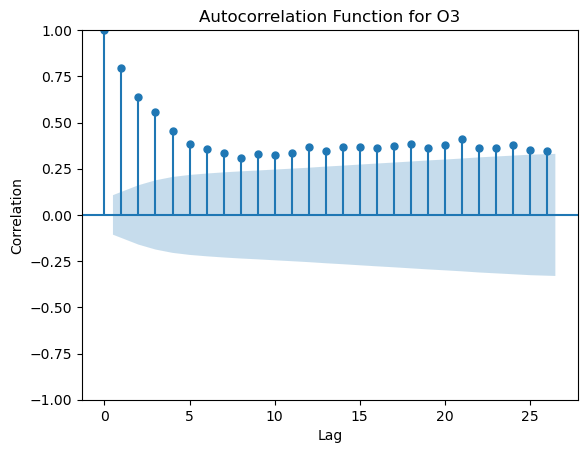

D:\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x500 with 0 Axes>

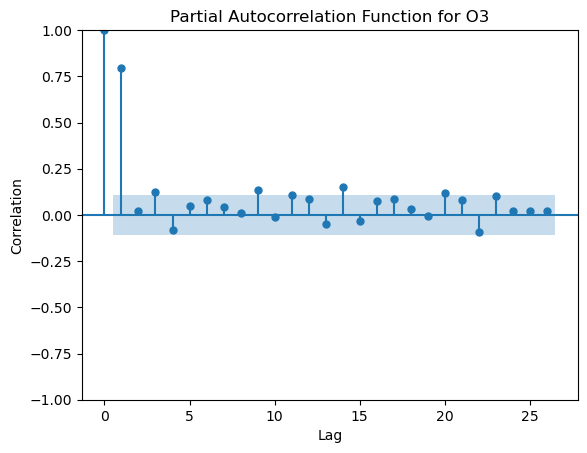

In [4]:
# Select the column to analyze, for example "NOx"
column_to_analyze = "O3"
ts_data = averaged_data[column_to_analyze]

# Plot the ACF
plt.figure(figsize=(12, 5))
plot_acf(ts_data)
plt.title(f"Autocorrelation Function for {column_to_analyze}")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

# Plot the PACF
plt.figure(figsize=(12, 5))
plot_pacf(ts_data)
plt.title(f"Partial Autocorrelation Function for {column_to_analyze}")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()


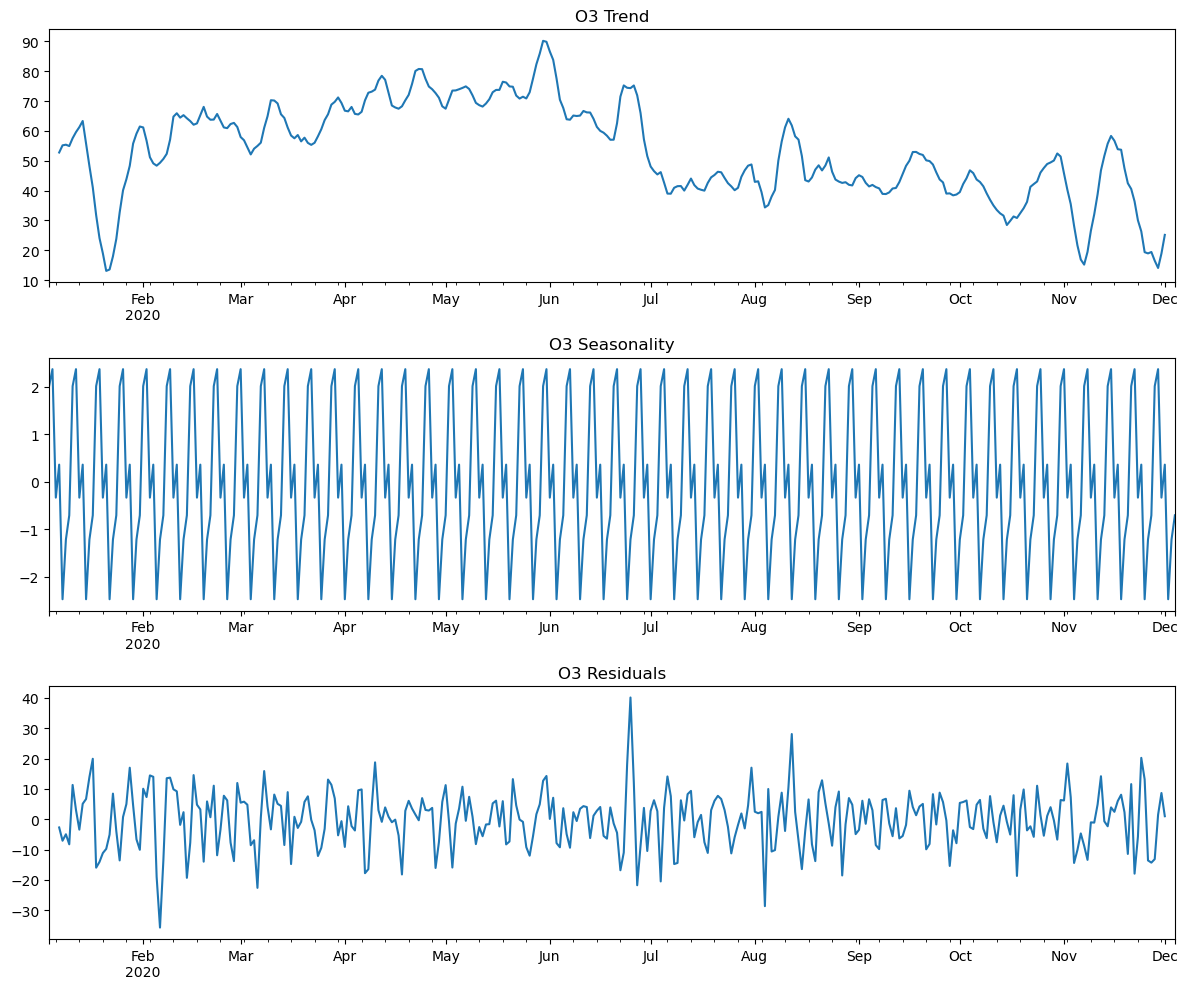

In [5]:
# Decompose the time series
decomposition = seasonal_decompose(ts_data, model='additive')

# Plot the trend, seasonality, and residuals
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
decomposition.trend.plot(ax=ax1)
ax1.set_title(f"{column_to_analyze} Trend")
decomposition.seasonal.plot(ax=ax2)
ax2.set_title(f"{column_to_analyze} Seasonality")
decomposition.resid.plot(ax=ax3)
ax3.set_title(f"{column_to_analyze} Residuals")
plt.tight_layout()
plt.show()


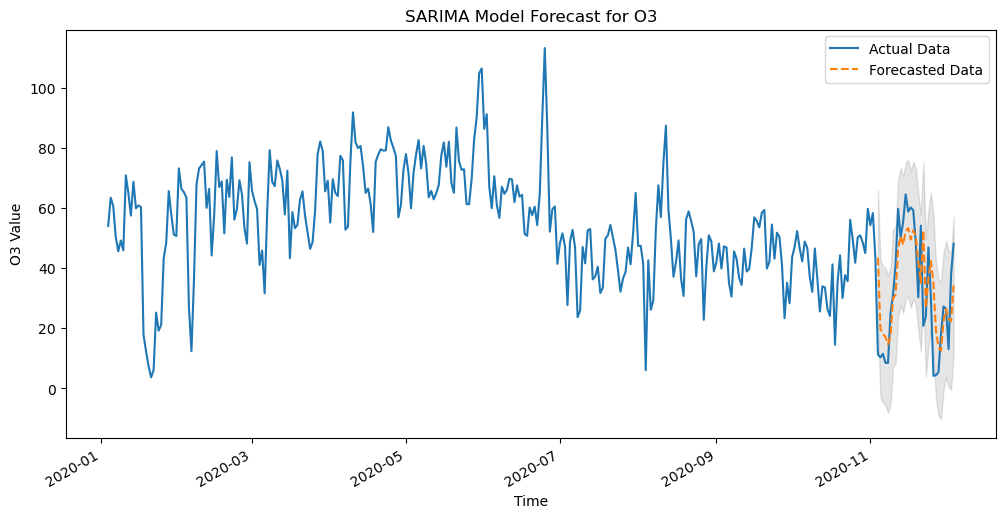

In [6]:
# Fit SARIMA model
sarima_model = SARIMAX(ts_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

# Predict future time series data
forecast = sarima_model.get_prediction(start=pd.to_datetime("2020-11-04"), end=pd.to_datetime("2020-12-04"), dynamic=False)

# Plot actual data and predicted values
plt.figure(figsize=(12, 6))
plt.plot(ts_data, label="Actual Data")
forecast.predicted_mean.plot(label="Forecasted Data", linestyle="--")
plt.fill_between(forecast.conf_int().index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color="k", alpha=0.1)
plt.title(f"SARIMA Model Forecast for {column_to_analyze}")
plt.xlabel("Time")
plt.ylabel(f"{column_to_analyze} Value")
plt.legend()
plt.show()


In [7]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

# Set the range of parameter values
p = d = q = range(0, 3)

# Generate all possible combinations of parameter values
pdq = list(itertools.product(p, d, q))

best_aic = float('inf')
best_params = None

for param in pdq:
    try:
        model = ARIMA(ts_data, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
    except:
        continue

print(f"Best parameters: {best_params}, AIC: {best_aic}")


D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best parameters: (2, 1, 2), AIC: 2599.5707297833496


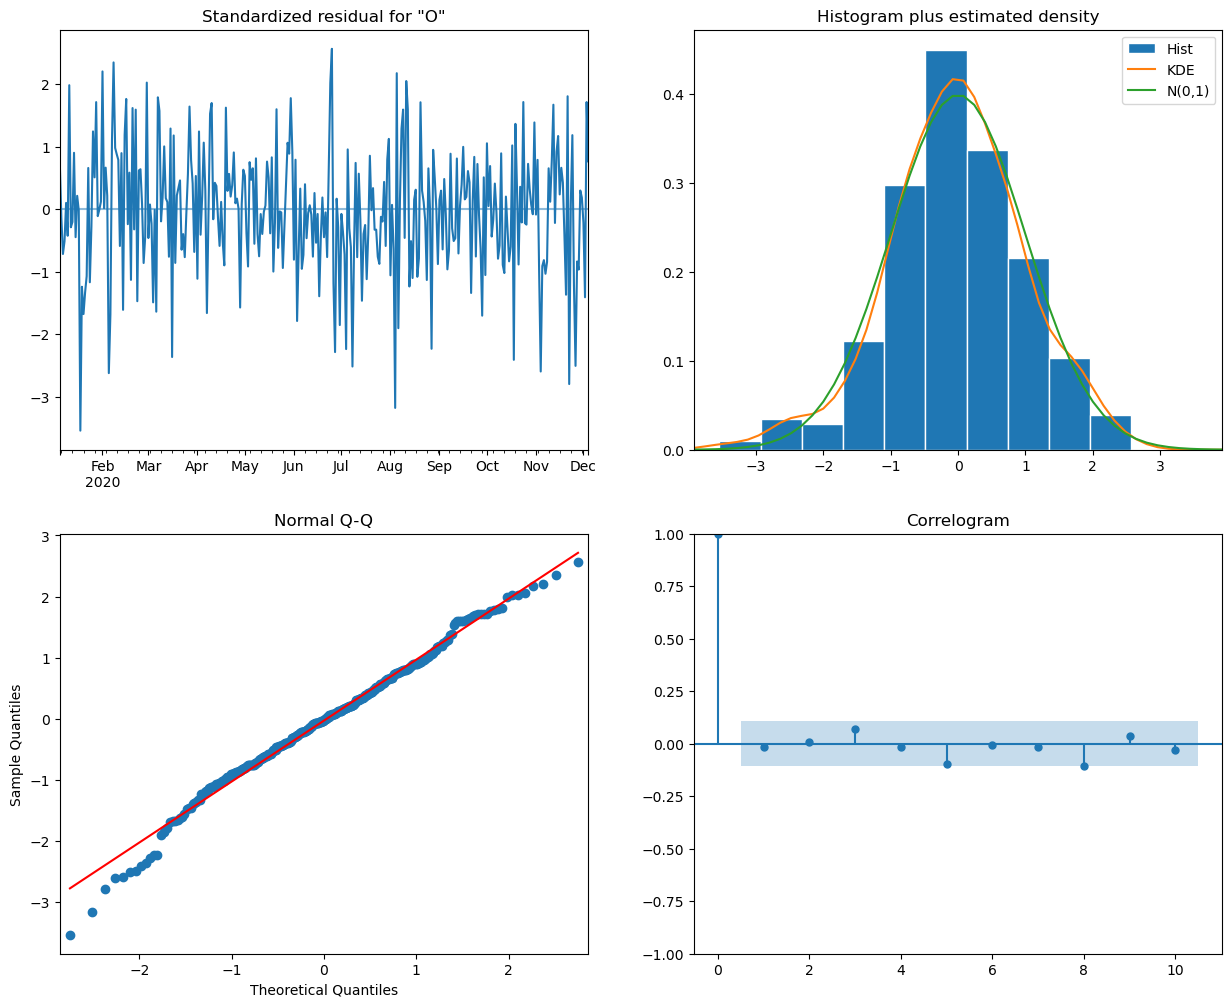

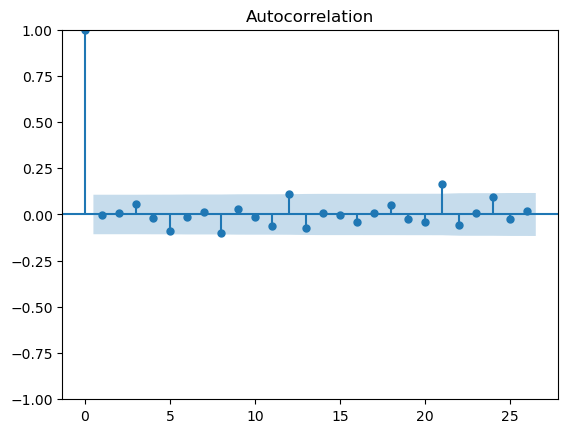

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

model = ARIMA(ts_data, order=best_params)
results = model.fit()

# diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# ACF
plot_acf(results.resid)
plt.show()